## Code for training model:
This code is for trianing mask rcnn model using the detectron2 github. For this change the file paths of coco dataset. (The dataset here was creating using labelme and then labelmetococo function was used to convert it to the proper dataset.) 

In [ ]:
# import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "1"


In [1]:
# Import Libraries:
import torch, detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
from detectron2.data import transforms as T
# import some common libraries
import numpy as np
import os, json, cv2, random

# import some common detectron2 utilities
from detectron2 import model_zoo, structures
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog, DatasetMapper

from detectron2.data.datasets import register_coco_instances


import labelme2cocoMy

c:\Users\faraboli\AppData\Local\miniconda3\envs\bubbleid\lib\site-packages\detectron2\model_zoo\model_zoo.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [31]:
import importlib

# recharge le module pour prendre en compte les modifications
labelme2cocoMy = importlib.reload(labelme2cocoMy)

<module 'labelme2cocoMy' from 'c:\\Users\\faraboli\\Desktop\\BubbleID\\BubbleIDGit\\ProjetBubbleID\\training\\labelme2cocoMy.py'>

Il faut generer le fichier coco pour le trainingset et le validation set

In [23]:
labelme_folder_path_train = "dataset\\train"
coco_path_train = "train.json"

labelme2cocoMy.labelme2coco(labelme_folder_path_train, coco_path_train)

labelme_folder_path_val = "dataset\\val"
coco_path_val = "val.json"

labelme2cocoMy.labelme2coco(labelme_folder_path_val, coco_path_val)

Conversion terminée : 139 images, 1280 annotations
Classes retenues : ['attached', 'detached', 'occludedAttached', 'occludedDetached']
Conversion terminée : 52 images, 560 annotations
Classes retenues : ['attached', 'detached', 'occludedAttached', 'occludedDetached']


In [24]:
for d in ["my_dataset_train", "my_dataset_test"]:
    if d in DatasetCatalog.list():
        DatasetCatalog.remove(d)
    if d in MetadataCatalog.list():
        MetadataCatalog.remove(d)
register_coco_instances("my_dataset_train", {}, coco_path_train, labelme_folder_path_train)

register_coco_instances("my_dataset_test", {}, coco_path_val, labelme_folder_path_val)

In [11]:
# pour verifier le nombre de classe et leur numerotation
import json

with open("train.json") as f:
    data = json.load(f)
num_classes = len(data["categories"])
print("Nombre de classes dans JSON COCO:", num_classes)
for c in data["categories"]:
    print(c["id"], c["name"])


Nombre de classes dans JSON COCO: 4
1 attached
2 detached
3 occludedAttached
4 occludedDetached


In [25]:
train_metadata = MetadataCatalog.get("my_dataset_train")
train_dataset_dicts = DatasetCatalog.get("my_dataset_train")

[10/03 15:38:33 d2.data.datasets.coco]: Loaded 139 images in COCO format from train.json


In [26]:
val_metadata = MetadataCatalog.get("my_dataset_test")
val_dataset_dicts = DatasetCatalog.get("my_dataset_test")

[10/03 15:38:35 d2.data.datasets.coco]: Loaded 52 images in COCO format from val.json


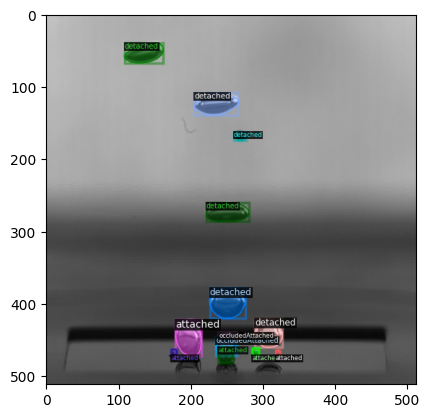

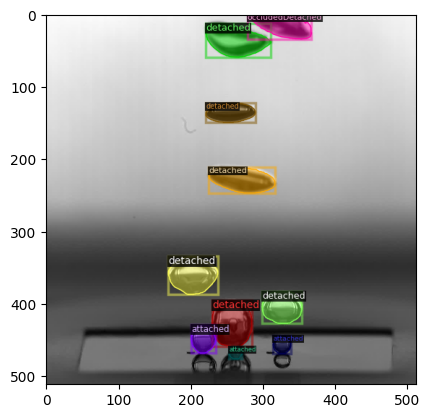

In [16]:
from matplotlib import pyplot as plt
for d in random.sample(train_dataset_dicts, 2):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    plt.imshow(vis.get_image()[:, :, ::-1])
    plt.show()

In [5]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.OUTPUT_DIR = "./Models"
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
#cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final_MATLAB1.pth")  # path to the model we just trained
cfg.SOLVER.IMS_PER_BATCH = 2  # This is the real "batch size" commonly known to deep learning people
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 1000    # 1000 iterations seems good enough for this dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256   # Default is 512, using 256 for this dataset.
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4  # We have 1 classes.
# NOTE: this config means the number of classes, without the background. Do not use num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
#trainer = DefaultTrainer(cfg) #Create an instance of of DefaultTrainer with the given congiguration
#trainer.resume_or_load(resume=False) #Load a pretrained model if available (resume training) or start training from scratch if no pretrained model is available


In [ ]:
from detectron2.data import detection_utils as utils
import detectron2.data.transforms as T
import copy
import torch

def custom_mapper(dataset_dict):
    dataset_dict = copy.deepcopy(dataset_dict)  # it will be modified by code below
    image = utils.read_image(dataset_dict["file_name"], format="BGR")
    
    mean = 0
    std_dev = 25
    gaussian_noise = np.random.normal(mean, std_dev, image.shape).astype(np.uint8)
    #noisy_image = cv2.add(image, gaussian_noise)
    
    transform_list = [
        #T.Resize((800,600)),
        T.RandomBrightness(0.8, 1.8),
        T.RandomContrast(0.6, 1.3),
        T.RandomSaturation(0.8, 1.4),
        #T.RandomRotation(angle=[90, 90]),
        #T.RandomNoise(mean=0.0, std=0.1),
        T.RandomLighting(0.7),
        T.RandomFlip(prob=0.4, horizontal=True, vertical=False),
    ]
    image, transforms = T.apply_transform_gens(transform_list, image)
    dataset_dict["image"] = torch.as_tensor(image.transpose(2, 0, 1).astype("float32"))

    annos = [
        utils.transform_instance_annotations(obj, transforms, image.shape[:2])
        for obj in dataset_dict.pop("annotations")
        if obj.get("iscrowd", 0) == 0
    ]
    instances = utils.annotations_to_instances(annos, image.shape[:2])
    dataset_dict["instances"] = utils.filter_empty_instances(instances)
    return dataset_dict

In [ ]:
from detectron2.engine import DefaultTrainer
from detectron2.data import build_detection_test_loader, build_detection_train_loader

class CustomTrainer(DefaultTrainer):
    @classmethod
    def build_train_loader(cls, cfg):
        return build_detection_train_loader(cfg, mapper=custom_mapper)

In [ ]:
trainer=CustomTrainer(cfg)
trainer.resume_or_load(resume=False)

trainer=DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)

from detectron2.data import DatasetMapper, build_detection_train_loader  # Import the necessary functions


class MyTrainer(DefaultTrainer):
    @classmethod
    def build_train_loader(cls, cfg):
        augmentations = [T.RandomBrightness(0.9, 1.1),
                         T.RandomFlip(prob=0.5),
                         T.RandomCrop("absolute", (640, 640))]
        
        mapper = DatasetMapper(cfg, is_train=True, augmentations=augmentations)
        return build_detection_train_loader(cfg, mapper=mapper)

trainer = MyTrainer(cfg)

class MyTrainer(DefaultTrainer):

    @classmethod
    def build_train_loader(cls, cfg):
        mapper = DatasetMapper(cfg, is_train=True, augmentations=T.AugmentationList([T.RandomBrightness(0.9,1.1),
                                                                                     T.RandomFlip(prob=0.5), 
                                                                                     T.RandomCrop("absolute", (640,640))]))
        return build_detection_train_loader(cfg, mapper=mapper)

#trainer = DefaultTrainer(cfg) 
#trainer = MyTrainer(cfg)
trainer.resume_or_load(resume=False)

In [ ]:
os.environ["TORCH_USE_CUDA_DSA"] = "1"

trainer.train() #Start the training process

In [ ]:
import yaml
# Save the configuration to a config.yaml file
# Save the configuration to a config.yaml file
config_yaml_path = "./Models/config.yaml"
with open(config_yaml_path, 'w') as file:
    yaml.dump(cfg, file)

In [30]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

[10/03 15:50:19 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output\model_final.pth ...


AssertionError: Checkpoint ./output\model_final.pth not found!

In [29]:
from detectron2.utils.visualizer import ColorMode

for d in random.sample(val_dataset_dicts, 1):    #select number of images for display
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=val_metadata,
                   scale=0.5,
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.imshow(out.get_image()[:,:,::-1])
    cv2.imshow(out.get_image()[:, :, ::-1])

NameError: name 'predictor' is not defined

In [ ]:
outputs

# Test of the performance

In [28]:
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2 import model_zoo

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4  # ou ton nombre de classes
cfg.MODEL.DEVICE = "cuda"

# Ancien modèle
cfg.MODEL.WEIGHTS = "../Customizable/model_final.pth"
predictor_old = DefaultPredictor(cfg)

# Nouveau modèle
cfg.MODEL.WEIGHTS = "Models/model_final.pth"
predictor_new = DefaultPredictor(cfg)


from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

evaluator = COCOEvaluator("my_dataset_test", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "my_dataset_test")



metrics_old = inference_on_dataset(predictor_old.model, val_loader, evaluator)
print("Ancien modèle :", metrics_old)

metrics_new = inference_on_dataset(predictor_new.model, val_loader, evaluator)
print("Nouveau modèle :", metrics_new)




[10/03 15:47:10 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ../Customizable/model_final.pth ...


Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (4, 1024) in the checkpoint but (5, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (4,) in the checkpoint but (5,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (12, 1024) in the checkpoint but (16, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (12,) in the checkpoint but (16,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (3, 256, 1, 1) in the checkpoint but (4, 256, 1, 1) in th

[10/03 15:47:11 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from Models/model_final.pth ...
WARNING [10/03 15:47:11 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[10/03 15:47:11 d2.data.datasets.coco]: Loaded 52 images in COCO format from val.json
[10/03 15:47:11 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[10/03 15:47:11 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[10/03 15:47:11 d2.data.common]: Serializing 52 elements to byte tensors and concatenating them all ...
[10/03 15:47:11 d2.data.common]: Serialized dataset takes 0.56 MiB
[10/03 15:47:11 d2.evaluation.evaluator]: Start inference on 52 batches
[10/03 15:47:17 d2.evaluation.evaluator]: Inference done 11/52. Dataloading: 0.0004 s/i